# Archival

In [3]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2022-12-20')
os.makedirs(tmp_path,exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
#SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
#DATA_PATH = path.join(SERVER_DIR, 'dataset', 'archival', 'archival_nli.json')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

m_kwargs = dict(
    n_context = 1, d_embedding=300
)

dm = ArchivalNLIDM(cache_path=DATA_CACHE,
     batch_size=16)

dm.prepare_data()
dm.setup('test')

model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='exp',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## Inference on cluster

In [8]:
import torch

MODEL_NAME = 'run=5_ncontext=1_vector=0_lentropy=0.018'

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

Model is in cuda:  False


In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from modules.utils import hightlight
df_rows = []

with torch.no_grad():

    for batch in tqdm(dm.test_dataloader()):
        batch = dm.collate(batch)
        padding_mask = batch['padding_mask']
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
                      hypothesis_ids=batch['hypothesis_ids'].to(device), 
                      premise_padding=padding_mask['premise'].to(device),
                      hypothesis_padding=padding_mask['hypothesis'].to(device))

        score = y_hat.softmax(-1)
        y_hat = y_hat.argmax(-1)
        a_hat['premise'] = a_hat['premise'].softmax(dim=1)
        a_hat['hypothesis'] = a_hat['hypothesis'].softmax(dim=1)

        for i in range(len(batch['premise_ids'])):
            df_rows.append({
                'premise': hightlight(batch['premise.form'][i], a_hat['premise'][i]),
                'hypothesis': hightlight(batch['hypothesis.form'][i], a_hat['hypothesis'][i]),
                'y_hat': y_hat[i].item(),
                'score': score[i,1].item(),
                'y_true': int(batch['y_true'][i]),
            })
        
df_rows = pd.DataFrame(df_rows)

In [ ]:
PREDICT_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions')
os.makedirs(PREDICT_PATH, exist_ok=True)
df_rows.to_json(path.join(PREDICT_PATH, MODEL_NAME+'.json'), orient='records')
print(f'Output json at {PREDICT_PATH}')

In [8]:
import json
html_str = '<table>'
html_str += '<thead><tr><th>Premise</th><th>Hypothesis</th><th>Prediction</th><th>Label</th></tr></thead>'
for row in df_rows:
    html_str += '<tr>'
    for k, v in row.items():
        html_str += '<td>'+str(v)+'</td>'
    html_str += '</tr>'

html_str += '</table>'
display(HTML(html_str))

with open(path.join(LOG_PATH, MODEL_NAME, 'predictions', 'inference.html'), 'w') as f:
    f.write(html_str)

AttributeError: 'str' object has no attribute 'items'

## Check Archival dataset

In [ ]:
import pandas as pd
testset = pd.read_parquet(path.join(DATA_CACHE, 'archival', 'archival_nli.parquet'))

In [109]:
testset.head()

,premise_tokens,premise_texts,hypothesis_tokens,hypothesis_texts,premise_id_block,hypothesis_id_block,premise_id_sentence,hypothesis_id_sentence,premise_space_after,hypothesis_space_after,label
0,"b'[""on"",""savoir"",""que"",""Fourier"",""\\u00eatre"",...","b'[""On"",""sait"",""que"",""Fourier"",""est"",""n\\u00e9...","b'[""monsieur"",""Rolande"",""Bonnain"",""-"",""Moerdyk...","b'[""Madame"",""Rolande"",""Bonnain"",""-"",""Moerdyk"",...",2,2,0,1,"b'[true,true,true,true,true,true,true,false,tr...","b'[true,true,false,false,true,true,true,true,t...",entailment
1,"b'[""monsieur"",""Rolande"",""Bonnain"",""-"",""Moerdyk...","b'[""Madame"",""Rolande"",""Bonnain"",""-"",""Moerdyk"",...","b'[""l\\u2019"",""ambition"",""de"",""Fourier"",""\\u00...","b'[""L\\u2019"",""ambition"",""de"",""Fourier"",""\\u00...",2,2,1,2,"b'[true,true,false,false,true,true,true,true,t...","b'[false,true,true,true,true,true,true,false,t...",entailment
2,"b'[""l\\u2019"",""ambition"",""de"",""Fourier"",""\\u00...","b'[""L\\u2019"",""ambition"",""de"",""Fourier"",""\\u00...","b'[""au"",""moment"",""o\\u00f9"",""Fourier"",""\\u00e9...","b'[""Au"",""moment"",""o\\u00f9"",""Fourier"",""\\u00e9...",2,2,2,3,"b'[false,true,true,true,true,true,true,false,t...","b'[true,true,true,true,false,true,false,true,t...",entailment
3,"b'[""au"",""moment"",""o\\u00f9"",""Fourier"",""\\u00e9...","b'[""Au"",""moment"",""o\\u00f9"",""Fourier"",""\\u00e9...","b'[""Fourier"",""tenir"",""compte"",""de"",""ce"",""circo...","b'[""Fourier"",""tient"",""compte"",""de"",""ces"",""circ...",2,2,3,4,"b'[true,true,true,true,false,true,false,true,t...","b'[true,true,true,true,true,true,false,true,tr...",entailment
4,"b'[""Fourier"",""tenir"",""compte"",""de"",""ce"",""circo...","b'[""Fourier"",""tient"",""compte"",""de"",""ces"",""circ...","b'[""en"",""harmonie"","","",""le"",""gastrosophe"",""\\u...","b'[""En"",""Harmonie"","","",""les"",""gastrosophes"",""s...",2,2,4,5,"b'[true,true,true,true,true,true,false,true,tr...","b'[true,false,true,true,true,true,true,true,tr...",entailment


In [32]:
for c in testset.columns:
    if isinstance(testset.loc[0, c], bytes):
        testset[c] = testset[c].str.decode("utf-8")
        testset[c] = testset[c].apply(pd.eval)

UndefinedVariableError: name 'true' is not defined

In [ ]:
testset.loc[0, 'premise_texts']

In [105]:
dm.test_set.data['premise'] = dm.test_set.data['premise_tokens'].apply(lambda x: ' '.join(x))

In [107]:
dm.test_set.data['premise']

0       iv . question non-résolue concerner le délégat...
1       disponible , grêver ce dernier de dette lourd ...
2       — un fait comptable : dans le compte de le soc...
3       quoi qu’ il en être , ce champignon séduire pa...
4                                      Hi Re pe # fa 5 se
                              ...                        
6851    et « c’ être pourquoi , conclure enfin René Sc...
6852    sans doute un grand partie de ce décision être...
6853    mais même de notre jour , toujours désireux de...
6854    encore jamais être aborder ; et ce œuvre colos...
6855    table rond à Censier sur le possibilité de l’ ...
Name: premise, Length: 6856, dtype: object

## Prediction in 1 block, explanation by sentence

In [ ]:
df_block = pd.read_json(path.join('autogestion_blocks.json'))

In [5]:
import pandas as pd
from data.functional import convert_utf8

df_block = pd.read_json(path.join('autogestion_blocks.json'))

def generate_sentence(block_data): 
    block_data = block_data.to_dict()
    sent_list = list()
    sent_token = list()
    for idx, token in enumerate(block_data['tokens']):
        sent_token.append(token)
            
        if token == '.':
            sent_list.append(sent_token)
            sent_token = list()
    return sent_list
        

block_1 = generate_sentence(df_block.loc[0])
print('Block 1:')
display(df_block.loc[0, 'text'])
print('Generated sentences:')
display([' '.join(p) for p in block_1])

print('='*10)

block_2 = generate_sentence(df_block.loc[1000])
print('Block 2:')
display(df_block.loc[1000, 'text'])
print('Generated sentences:')
display([' '.join(p) for p in block_2])

Block 1:


"On sait que Fourier est né à l’époque des premiers restaurants. Madame Rolande Bonnain-Moerdyk a montré dans quelle mesure l’inventeur de la « gastrosophie » peut être considéré comme le premier gastronome moderne. L’ambition de Fourier à ce sujet était, nous dit-elle, de supplanter son beau-frère, Brillat-Savarin, auteur de la Physiologie du Goût (1825). Au moment où Fourier écrit, l’alimentation de ses contemporains s’enrichit —le sucre devient un produit de consommation courante, et un genre nouveau apparaît en littérature : on écrit des livres « où il est question de manger ». Fourier tient compte de ces circonstances lorsqu'il définit la gastrosophie comme « l'alliance de la sagesse et des sciences utiles, comme l’hygiène et l'agronomie, avec le matériel de la gourmandise ratfinée ». En Harmonie, les gastrosophes seront les médecins officieux des hommes dont ils multiplient les goûts afin qu’ils puissent désirer tous les produits que l’ordre sociétaire proposera. L’hygiène consis

Generated sentences:


['On sait que Fourier est né à l’ époque des premiers restaurants .',
 'Madame Rolande Bonnain - Moerdyk a montré dans quelle mesure l’ inventeur de la « gastrosophie » peut être considéré comme le premier gastronome moderne .',
 'L’ ambition de Fourier à ce sujet était , nous dit -elle , de supplanter son beau-frère , Brillat - Savarin , auteur de la Physiologie du Goût ( 1825 ) .',
 'Au moment où Fourier écrit , l’ alimentation de ses contemporains s’ enrichit — le sucre devient un produit de consommation courante , et un genre nouveau apparaît en littérature : on écrit des livres « où il est question de manger » .',
 "Fourier tient compte de ces circonstances lorsqu' il définit la gastrosophie comme « l' alliance de la sagesse et des sciences utiles , comme l’ hygiène et l' agronomie , avec le matériel de la gourmandise ratfinée » .",
 'En Harmonie , les gastrosophes seront les médecins officieux des hommes dont ils multiplient les goûts afin qu’ ils puissent désirer tous les produi

Block 2:


"L’industrialisation a exposé des résultats. Une série d'industries transformatrices occupaient graduellement la place de la production primaire basée sur l’agriculture ou sur les industries extractives. Le développement des branches industrielles qui étaient dans des conditions favoralbles en ce qui concerne les sources naturelles ainsi que la création et le développement des industries de transformation des métaux élargissaient le domaine de lexportation. L'agriculture, qui a retrouvé ses positions d’avant guerre, occupait une place de plus en plus grande à côté de l’industrie. La caractéristique générale des exportations yougoslaves d’après guerre est la tendance de plus en plus marquée à exporter des produits industriels traités et finis. De même, la période à partir de 1956 est caractérisée par l’accession de la Yougoslavie au marché mondial comme pays exportateur de machines, de navires, d'équipement et d’installations industrielles complètes, comme constructeur de divers ouvrage

Generated sentences:


['L’ industrialisation a exposé des résultats .',
 "Une série d' industries transformatrices occupaient graduellement la place de la production primaire basée sur l’ agriculture ou sur les industries extractives .",
 'Le développement des branches industrielles qui étaient dans des conditions favoralbles en ce qui concerne les sources naturelles ainsi que la création et le développement des industries de transformation des métaux élargissaient le domaine de lexportation .',
 "L' agriculture , qui a retrouvé ses positions d’ avant guerre , occupait une place de plus en plus grande à côté de l’ industrie .",
 'La caractéristique générale des exportations yougoslaves d’ après guerre est la tendance de plus en plus marquée à exporter des produits industriels traités et finis .',
 "De même , la période à partir de 1956 est caractérisée par l’ accession de la Yougoslavie au marché mondial comme pays exportateur de machines , de navires , d' équipement et d’ installations industrielles complè

In [9]:
sent_pairs = {'premise': list(), 'hypothesis': list()}
for b1 in block_1:
    for b2 in block_2:
        sent_pairs['premise'].append(b1)
        sent_pairs['hypothesis'].append(b2)

batch = dm.collate({
    'premise_tokens' : sent_pairs['premise'],
    'hypothesis_tokens': sent_pairs['hypothesis'],
    'label': ['neutral']
})

model.eval()
y_hat, a_hat = model(premise_ids=batch['premise_ids'], 
    hypothesis_ids=batch['hypothesis_ids'], 
    premise_padding=batch['padding_mask']['premise'],
    hypothesis_padding=batch['padding_mask']['hypothesis'])

links = y_hat.argmax(1)

print('#block_1:', len(block_1))
print('#block_2:', len(block_2))
print('#pairs:', len(sent_pairs['premise']))
print('#links:', sum(links))

#block_1: 7
#block_2: 6
#pairs: 42
#links: tensor(30)


In [27]:
for idx in range(10):
    if links[idx]:
        print('premise :', ' '.join(sent_pairs['premise'][idx]))
        print('hypothesis:', ' '.join(sent_pairs['hypothesis'][idx]))
        print('='*10)

premise : On sait que Fourier est né à l’ époque des premiers restaurants .
hypothesis: Le développement des branches industrielles qui étaient dans des conditions favoralbles en ce qui concerne les sources naturelles ainsi que la création et le développement des industries de transformation des métaux élargissaient le domaine de lexportation .
premise : On sait que Fourier est né à l’ époque des premiers restaurants .
hypothesis: L' agriculture , qui a retrouvé ses positions d’ avant guerre , occupait une place de plus en plus grande à côté de l’ industrie .
premise : On sait que Fourier est né à l’ époque des premiers restaurants .
hypothesis: De même , la période à partir de 1956 est caractérisée par l’ accession de la Yougoslavie au marché mondial comme pays exportateur de machines , de navires , d' équipement et d’ installations industrielles complètes , comme constructeur de divers ouvrages industriels .


In [28]:
display(links)
matrix = links.view(7,6)
display(matrix)

tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

tensor([[0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])

In [33]:
hl_sent = {
    'premise': matrix.float().mean(1).tolist(),
    'hypothesis': matrix.float().mean(0).tolist()
}
html_hl_sent = dict()
for side, txt  in zip(['premise', 'hypothesis'], [block_1, block_2]):
    html_hl_sent[side] = [
        '<span style="background-color:rgba(135,206,250,' + str(hl_sent[side][i]) + ');">' + ' '.join(txt[i]) + '</span> ' for i in range(len(txt))
    ]

In [42]:
print('Block 1')
display(HTML(' '.join(html_hl_sent['premise'])))
print('='*10)
print('Block 2')
display(HTML(' '.join(html_hl_sent['hypothesis'])))

Block 1


Block 2


## Prediction in block, explanation by words

In [ ]:
import torch

MODEL_NAME = 'run=3_ncontext=1_vector=0_lentropy=0.01'

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

In [40]:
import pandas as pd
df_block = pd.read_json(path.join('archival','blocs.json'), 'records',encoding='utf-8')
df_block.head(3)

/tmp/ipykernel_35538/1868566475.py:2: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  df_block = pd.read_json(path.join('archival','blocs.json'), 'records',encoding='utf-8')


,revue.id,article.id,article.title,page.id,bloc.id,comment,n_tokens,tokens,text,sents
0,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_1928,Présentation de la revue,[autog_0005-0970_1966_num_1_1_T1_0003_0000_710],0,#id=block_0,103,"[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemma...",Les cahiers de |' « AUTOGESTION » se proposent...,"[[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemm..."
1,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_1928,Présentation de la revue,[autog_0005-0970_1966_num_1_1_T1_0003_0000_710],1,#id=block_1,53,"[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemma...",Les articles signés traitant des aspects théor...,"[[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemm..."
2,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_1928,Présentation de la revue,[autog_0005-0970_1966_num_1_1_T1_0003_0000_710],2,#id=block_2,31,"[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemma...",Les cahiers de l' « AUTOGESTION » paraîtront t...,"[[{'norm': 'le', 'id': 1, 'form': 'Les', 'lemm..."


In [ ]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
DATA_PATH = path.join(SERVER_DIR, 'dataset', 'archival', 'archival_nli.json')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

m_kwargs = dict(
    n_context = 1, d_embedding=300
)

dm = ArchivalNLIDM(cache_path=DATA_CACHE,
     batch_size=16,
     data_path=DATA_PATH)

dm.prepare_data()
dm.setup('test')

model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='exp',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [ ]:
def inference_blocks(source, target, model):
    sent_pairs = {'source': list(), 'target': list(), 'id_source': list(), 'id_target': list()}

    for idx_src, sent_src in enumerate(source['token_lemma']):
        for idx_target, sent_target in enumerate(target['token_lemma']):
            sent_pairs['source'].append(sent_src)
            sent_pairs['id_source'].append(idx_src)
            sent_pairs['target'].append(sent_target)
            sent_pairs['id_target'].append(idx_target)

    batch = dm.collate({
        'premise_tokens' : sent_pairs['source'],
        'hypothesis_tokens': sent_pairs['target'],
    })
    
    y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
        hypothesis_ids=batch['hypothesis_ids'].to(device), 
        premise_padding=batch['padding_mask']['premise'].to(device),
        hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))

    # normalize output
    y_hat = y_hat.softmax(-1)    
    a_hat = { s: a_hat[s].softmax(-1) for s in a_hat }
    
    y_hat = y_hat[:, 1]
    sentence_links = y_hat.reshape(source['n_sents'], target['n_sents'])
    
    attention = dict()
    
    len_sent = a_hat['premise'].shape[-1]
    d_y_hat = y_hat.shape[0]
    attention['source'] = a_hat['premise'] * y_hat.unsqueeze(1).repeat(1, len_sent)
    attention['source'] = attention['source'].reshape(source['n_sents'], target['n_sents'], -1)
    attention['source'] = attention['source'].sum(1)
    
    len_sent = a_hat['hypothesis'].shape[-1]
    attention['target'] = a_hat['hypothesis'] * y_hat.unsqueeze(1).repeat(1, len_sent)
    attention['target'] = attention['target'].reshape(target['n_sents'], source['n_sents'], -1)
    attention['target'] = attention['target'].sum(1)
    
    attention['source'] = [attention[~padding_mask].tolist() for attention, padding_mask in zip(attention['source'], batch['padding_mask']['premise'])]
    attention['target'] = [attention[~padding_mask].tolist() for attention, padding_mask in zip(attention['target'], batch['padding_mask']['hypothesis'])]
    
    score = y_hat.mean().item()
    
    return {
        'score': score,
        'attention': attention,
        'sentence_links': sentence_links.tolist()
    }

source = df_block.iloc[10]
target = df_block.iloc[11]

result = inference_blocks(source, target, model)

In [79]:
from tqdm.auto import trange

links = []
model.eval()

from itertools import product

with torch.no_grad():
    for idx_source in trange(500):
        for idx_target in range(idx_source, 500):

            source = df_block.iloc[idx_source]
            target = df_block.iloc[idx_target]
            result = inference_blocks(source, target, model)

            link = {
                'source.id_block': source['id_block'],
                'target.id_block': target['id_block'],
                
                'source.id_revue': source['id_revue'],
                'target.id_revue': target['id_revue'],
                
                'source.title': source['title'],
                'target.title': target['title'],
                
                'source.text' : source['text'],
                'target.text' : target['text'],
                
                'source.tokens' : source['tokens'],
                'target.tokens' : target['tokens'],
                
                'score' : result['score'],
                'sentence_links': result['sentence_links'],
                'source.attention': result['attention']['source'],
                'target.attention': result['attention']['target'],
            }
            links.append(link)

  0%|          | 0/500 [00:00<?, ?it/s]

In [80]:
df_link = pd.DataFrame(links)

In [81]:
len(df_link)

125250

In [82]:
df_link[(df_link['source.id_revue']!=df_link['target.id_revue']) & (df_link['score'] > 0.5)][:5]

,source.id_block,target.id_block,source.id_revue,target.id_revue,source.title,target.title,source.text,target.text,source.tokens,target.tokens,score,sentence_links,source.attention,target.attention
442,block_4,block_2,FMSH_PB188a_00001,FMSH_PB188a_00002,Georges Gurvitch : une théorie sociologique de...,L'autogestion à la lumière du marxisme,Des chances d'intervention de ces groupes dans...,L'autogestion doit ètre en somme remise à sa p...,"[[Des, chances, d', intervention, de, ces, gro...","[[L', autogestion, doit, ètre, en, somme, remi...",0.585743,"[[0.5003994703292847, 0.9694411158561707, 0.87...","[[0.08444046229124069, 0.07278954982757568, 0....","[[0.09478897601366043, 0.10767434537410736, 0...."
445,block_4,block_1,FMSH_PB188a_00001,FMSH_PB188a_00002,Georges Gurvitch : une théorie sociologique de...,L’autogestion ouvrière en Yougoslavie,Des chances d'intervention de ces groupes dans...,sont séparés économiquement des moyens de prod...,"[[Des, chances, d', intervention, de, ces, gro...","[[sont, séparés, économiquement, des, moyens, ...",0.611050,"[[0.6113032698631287, 0.8858933448791504], [0....","[[0.07186143845319748, 0.05925358831882477, 0....","[[0.039582621306180954, 0.07995999604463577, 0..."
447,block_4,block_5,FMSH_PB188a_00001,FMSH_PB188a_00002,Georges Gurvitch : une théorie sociologique de...,L’autogestion ouvrière en Yougoslavie,Des chances d'intervention de ces groupes dans...,"Théoriquement, l’autogestion ouvrière se conço...","[[Des, chances, d', intervention, de, ces, gro...","[[Théoriquement, ,, l’, autogestion, ouvrière,...",0.524893,"[[0.7540214657783508, 0.8227774500846863, 0.50...","[[0.17564471065998077, 0.1739562749862671, 0.1...","[[0.04431349039077759, 0.07483076304197311, 0...."
450,block_4,block_2,FMSH_PB188a_00001,FMSH_PB188a_00002,Georges Gurvitch : une théorie sociologique de...,L'autogestion à la lumière du marxisme,Des chances d'intervention de ces groupes dans...,"C’est ainsi, pensons-nous que l’on peut poser ...","[[Des, chances, d', intervention, de, ces, gro...","[[C’, est, ainsi, ,, pensons, -nous, que, l’, ...",0.655013,"[[0.6068068146705627, 0.9833873510360718, 0.97...","[[0.4761011600494385, 0.4498608112335205, 0.55...","[[0.049289822578430176, 0.05245901644229889, 0..."
452,block_4,block_3,FMSH_PB188a_00001,FMSH_PB188a_00002,Georges Gurvitch : une théorie sociologique de...,Pologne-Hongrie ou «Le Printemps en Octobre» ....,Des chances d'intervention de ces groupes dans...,"Ainsi, en Pologne, le mouvement de démocratisa...","[[Des, chances, d', intervention, de, ces, gro...","[[Ainsi, ,, en, Pologne, ,, le, mouvement, de,...",0.636157,"[[0.7253460884094238, 0.9655166864395142, 0.84...","[[0.12059307098388672, 0.12423186004161835, 0....","[[0.03619016706943512, 0.03912396728992462, 0...."


In [ ]:
from modules.utils import hightlight

In [83]:
interesting_links = df_link[(df_link['source.id_revue']!=df_link['target.id_revue']) & (df_link['score'] > 0.5)]
interesting_links = interesting_links.sort_values(by='score', ascending=False)
interesting_links.head(5)

,source.id_block,target.id_block,source.id_revue,target.id_revue,source.title,target.title,source.text,target.text,source.tokens,target.tokens,score,sentence_links,source.attention,target.attention
105131,block_4,block_2,FMSH_PB188a_00001,FMSH_PB188a_00002,Principaux extraits de l'œuvre de Georges Gurv...,"Principes, types et problèmes de la démocratie...",Cependant le principe pluraliste implique plus...,La démocratie du kibboutz n'est pas seulement ...,"[[Cependant, le, principe, pluraliste, impliqu...","[[La, démocratie, du, kibboutz, n', est, pas, ...",0.999677,"[[0.999974250793457, 0.9998972415924072], [0.9...","[[0.16516536474227905, 0.28219640254974365, 0....","[[0.025063935667276382, 0.03181426227092743, 0..."
116966,block_6,block_2,FMSH_PB188a_00001,FMSH_PB188a_00002,Principaux extraits de l'œuvre de Georges Gurv...,"Principes, types et problèmes de la démocratie...",portions inquiétantes. Il est bien connu qu’à ...,Etant donné que les récompenses dans le kibbou...,"[[portions, inquiétantes, .], [Il, est, bien, ...","[[Etant, donné, que, les, récompenses, dans, l...",0.999673,"[[0.9999005794525146, 0.9991657733917236], [0....","[[0.9372556805610657, 0.44369059801101685, 0.6...","[[0.17584288120269775, 0.1497732549905777, 0.0..."
88641,block_5,block_6,FMSH_PB188a_00001,FMSH_PB188a_00002,Perspectives de l’autogestion en Algérie,"Principes, types et problèmes de la démocratie...",Les Communistes Yougoslaves sont partis d'un «...,"Par cette enquête, nous nous sommes efforcés d...","[[Les, Communistes, Yougoslaves, sont, partis,...","[[Par, cette, enquête, ,, nous, nous, sommes, ...",0.999612,"[[0.999890923500061, 0.9991639852523804, 0.999...","[[0.16094240546226501, 0.11563065648078918, 0....","[[0.04615941271185875, 0.04160848259925842, 0...."
116964,block_6,block_4,FMSH_PB188a_00001,FMSH_PB188a_00002,Principaux extraits de l'œuvre de Georges Gurv...,Les problèmes de l'autogestion dans les grande...,portions inquiétantes. Il est bien connu qu’à ...,Chaque Président de comité de gestion question...,"[[portions, inquiétantes, .], [Il, est, bien, ...","[[Chaque, Président, de, comité, de, gestion, ...",0.999585,"[[0.9982472658157349, 0.9999940395355225, 0.99...","[[1.192434310913086, 0.7949380874633789, 1.010...","[[0.06481712311506271, 0.02475344017148018, 0...."
58436,block_4,block_2,FMSH_PB188a_00001,FMSH_PB188a_00002,Principaux extraits de l'œuvre de Georges Gurv...,"Principes, types et problèmes de la démocratie...",La troisième manière d'établir dans l'usine la...,La démocratie du kibboutz n'est pas seulement ...,"[[La, troisième, manière, d', établir, dans, l...","[[La, démocratie, du, kibboutz, n', est, pas, ...",0.999570,"[[0.9999122619628906, 0.9993557333946228], [0....","[[0.03865012526512146, 0.02225872129201889, 0....","[[0.05449565127491951, 0.046941712498664856, 0..."


In [96]:
N_EXAMPLE=10
html = '<table><thead>'+\
        '<tr><th>Source</th> <th>Target</th> <th>Score</th></tr>' +\
        '</thead>'

html += '<tbody>'
for index, data in interesting_links[10:10+N_EXAMPLE].iterrows():
    html += '<tr>'
    
    tokens = [token for sentence in data['target.tokens'] for token in sentence]
    attention = [att for sentence in data['target.attention'] for att in sentence]
    html += '<td>'+ hightlight(tokens, attention) +'<br><b>(' + data['target.title'] +')</b></td>'
    
    tokens = [token for sentence in data['source.tokens'] for token in sentence]
    attention = [att for sentence in data['source.attention'] for att in sentence]
    html += '<td>'+ hightlight(tokens, attention) +'<br><b>(' + data['source.title'] +')</b></td>'
    
    html += '<td>'+ str(round(data['score'],3)) +'</td>'
    html += '</tr>'
    
html += '</tbody></table>'
display(HTML(html))

In [91]:
df_link.to_json('links.json', orient='records', indent=4)

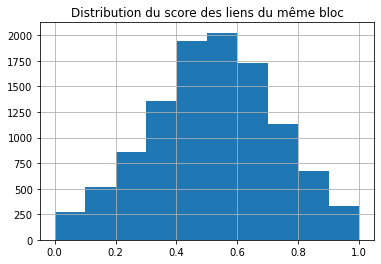

In [92]:
import matplotlib.pyplot as plt

df_link[(df_link['source.id_block'] == df_link['target.id_block']) & (df_link['source.id_revue'] == df_link['target.id_revue'])]['score'].hist()
plt.title("Distribution du score des liens du même bloc")
plt.savefig('archival/autogestion_self_block.jpg')

In [97]:
df_link[(df_link['source.id_block'] == df_link['target.id_block']) & (df_link['source.id_revue'] == df_link['target.id_revue'])]

,source.id_block,target.id_block,source.id_revue,target.id_revue,source.title,target.title,source.text,target.text,source.tokens,target.tokens,score,sentence_links,source.attention,target.attention
0,block_4,block_4,FMSH_PB188a_00001,FMSH_PB188a_00001,Georges Gurvitch : une théorie sociologique de...,Georges Gurvitch : une théorie sociologique de...,Des chances d'intervention de ces groupes dans...,Des chances d'intervention de ces groupes dans...,"[[Des, chances, d', intervention, de, ces, gro...","[[Des, chances, d', intervention, de, ces, gro...",0.483251,"[[0.8051419258117676, 0.6842369437217712, 0.39...","[[0.08846492320299149, 0.08627260476350784, 0....","[[0.07189453393220901, 0.047715578228235245, 0..."
9,block_4,block_4,FMSH_PB188a_00001,FMSH_PB188a_00001,Georges Gurvitch : une théorie sociologique de...,Henri Lefebvre ouvre le débat sur la théorie d...,Des chances d'intervention de ces groupes dans...,a) L'autogestion naît et renaît au sein d'une ...,"[[Des, chances, d', intervention, de, ces, gro...","[[a, ), L', autogestion, naît, et, renaît, au,...",0.308248,"[[0.019018730148673058, 0.9406344294548035, 0....","[[0.12190473079681396, 0.11910244822502136, 0....","[[0.04013747349381447, 0.05658392608165741, 0...."
15,block_4,block_4,FMSH_PB188a_00001,FMSH_PB188a_00001,Georges Gurvitch : une théorie sociologique de...,De Freinet à l'autogestion pédagogique,Des chances d'intervention de ces groupes dans...,Rousseau avait bien vu la difficulté sur le pl...,"[[Des, chances, d', intervention, de, ces, gro...","[[Rousseau, avait, bien, vu, la, difficulté, s...",0.398883,"[[0.6365015506744385, 0.7741187810897827, 0.44...","[[0.17603754997253418, 0.1731647253036499, 0.1...","[[0.089361272752285, 0.06022285670042038, 0.08..."
19,block_4,block_4,FMSH_PB188a_00001,FMSH_PB188a_00001,Georges Gurvitch : une théorie sociologique de...,Henri Lefebvre ouvre le débat sur la théorie d...,Des chances d'intervention de ces groupes dans...,Le réformisme s'érigea en idéologie réaliste e...,"[[Des, chances, d', intervention, de, ces, gro...","[[Le, réformisme, s', érigea, en, idéologie, r...",0.584444,"[[0.6769669055938721, 0.8200157880783081, 0.55...","[[0.20150168240070343, 0.20366376638412476, 0....","[[0.10184687376022339, 0.20479002594947815, 0...."
21,block_4,block_4,FMSH_PB188a_00001,FMSH_PB188a_00001,Georges Gurvitch : une théorie sociologique de...,Principaux extraits de l'œuvre de Georges Gurv...,Des chances d'intervention de ces groupes dans...,(5) Voir sur les conseils d'usine en Allemagne...,"[[Des, chances, d', intervention, de, ces, gro...","[[(, 5, ), Voir, sur, les, conseils, d', usine...",0.461636,"[[0.9927329421043396, 0.9342244863510132, 0.81...","[[0.2618171274662018, 0.2686716616153717, 0.32...","[[0.06914599984884262, 0.07270538061857224, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125238,block_5,block_5,FMSH_PB188a_00002,FMSH_PB188a_00002,L’autogestion et les managers,L’autogestion ouvrière en Yougoslavie,Puisque les critiques formulées contre l’autog...,Le rendement personnel est sans doute aussi à ...,"[[Puisque, les, critiques, formulées, contre, ...","[[Le, rendement, personnel, est, sans, doute, ...",0.089036,"[[0.06960441917181015, 0.036233752965927124, 0...","[[0.006260855123400688, 0.008458277210593224, ...","[[0.004614298231899738, 0.004688210319727659, ..."
125240,block_1,block_1,FMSH_PB188a_00002,FMSH_PB188a_00002,L’autogestion ouvrière en Yougoslavie,L’autogestion ouvrière en Yougoslavie,Il faut souligner à ce sujet que les ouvriers ...,Il faut souligner à ce sujet que les ouvriers ...,"[[Il, faut, souligner, à, ce, sujet, que, les,...","[[Il, faut, souligner, à, ce, sujet, que, les,...",0.629133,"[[0.8591553568840027, 0.29304471611976624], [0...","[[0.021275922656059265, 0.010645458474755287, ...","[[0.030077792704105377, 0.02153988555073738, 0..."
125244,block_3,block_3,FMSH_PB188a_00002,FMSH_PB188a_00002,L’autogestion ouvrière en Yougoslavie,L’autogestion ouvrière en Yougoslavie,

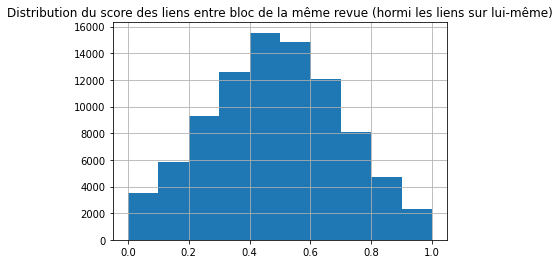

In [98]:
df_link[(df_link['source.id_block'] != df_link['target.id_block']) & (df_link['source.id_revue'] == df_link['target.id_revue'])]['score'].hist()
plt.title("Distribution du score des liens entre bloc de la même revue (hormi les liens sur lui-même)")
plt.savefig('archival/autogestion_same_revue_score.jpg')

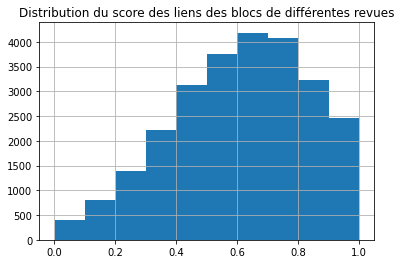

In [99]:
df_link[df_link['source.id_revue'] != df_link['target.id_revue']]['score'].hist()
plt.title("Distribution du score des liens des blocs de différentes revues")
plt.savefig('archival/autogestion_diff_revue_score.jpg')

## Prediction in new bloc vesion

In [ ]:
import pandas as pd
df_block = pd.read_json(path.join('archival','blocs.json'), 'records',encoding='utf-8')
df_block['page.id'] = df_block['page.id'].apply(lambda x: x[0])
df_block['sents.norm'] = df_block['sents'].apply(lambda x: [[token['norm'] for token in sent] for sent in x])
df_block['n_sents'] = df_block.sents.str.len()
df_block.head(3)

In [ ]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
DATA_PATH = path.join(SERVER_DIR, 'dataset', 'archival', 'archival_nli.json')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

m_kwargs = dict(
    n_context = 1, d_embedding=300
)

dm = ArchivalNLIDM(cache_path=DATA_CACHE,
     batch_size=16,
     data_path=DATA_PATH)

dm.prepare_data()
dm.setup('test')

model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='exp',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model.to(device)
model.eval()

In [ ]:
def inference_blocks(source, target, model, agg=None):
    sent_pairs = {'source': list(), 'target': list(), 'id_source': list(), 'id_target': list()}

    for idx_src, sent_src in enumerate(source['sents.norm']):
        for idx_target, sent_target in enumerate(target['sents.norm']):
            sent_pairs['source'].append(sent_src)
            sent_pairs['id_source'].append(idx_src)
            sent_pairs['target'].append(sent_target)
            sent_pairs['id_target'].append(idx_target)

    batch = dm.collate({
        'premise.norm' : sent_pairs['source'],
        'hypothesis.norm': sent_pairs['target'],
    })
    
    y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
        hypothesis_ids=batch['hypothesis_ids'].to(device), 
        premise_padding=batch['padding_mask']['premise'].to(device),
        hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))

    # normalize output
    y_hat = y_hat.softmax(-1)    
    a_hat = { s: a_hat[s].softmax(-1) for s in a_hat }
    
    y_hat = y_hat[:, 1]
    
    # mode aggregation
    if agg == 'filter':
        y_hat[y_hat < 0.5] = 0
    
    sentence_links = y_hat.reshape(source['n_sents'], target['n_sents'])
    
    attention = dict()
    
    len_sent = a_hat['premise'].shape[-1]
    attention['source'] = a_hat['premise'] * y_hat.unsqueeze(1).repeat(1, len_sent)
    attention['source'] = attention['source'].reshape(source['n_sents'], target['n_sents'], -1)
    attention['source'] = attention['source'].sum(1)
    
    len_sent = a_hat['hypothesis'].shape[-1]
    attention['target'] = a_hat['hypothesis'] * y_hat.unsqueeze(1).repeat(1, len_sent)
    attention['target'] = attention['target'].reshape(target['n_sents'], source['n_sents'], -1)
    attention['target'] = attention['target'].sum(1)
    
    attention['source'] = [attention[~padding_mask].tolist() for attention, padding_mask in zip(attention['source'], batch['padding_mask']['premise'])]
    attention['target'] = [attention[~padding_mask].tolist() for attention, padding_mask in zip(attention['target'], batch['padding_mask']['hypothesis'])]
    
    if agg == 'filter':
        if (y_hat > 0).sum() == 0:
            score = torch.tensor([0.0])
        else:
            score = y_hat[y_hat > 0].mean()
    elif agg == 'max':
        score = y_hat.max()
    elif agg == None:
        score = y_hat.mean()
    
    
    score = score.item()
    
    return {
        'score': score,
        'attention': attention,
        'sentence_links': sentence_links.tolist()
    }

source = df_block.iloc[10]
target = df_block.iloc[11]

result = inference_blocks(source, target, model, 'filter')

In [ ]:
from tqdm.auto import trange

links = []
model.eval()

from itertools import product

with torch.no_grad():
    for idx_source in trange(500):
        for idx_target in range(idx_source, 500):

            source = df_block.iloc[idx_source]
            target = df_block.iloc[idx_target]
            result = inference_blocks(source, target, model)

            link = {
                'source.bloc.id': source['bloc.id'],
                'target.bloc.id': target['bloc.id'],
                
                'source.revue.id': source['revue.id'],
                'target.revue.id': target['revue.id'],
                
                'source.title': source['article.title'],
                'target.title': target['article.title'],
                
                'source.text' : source['text'],
                'target.text' : target['text'],
                
                'source.norm' : source['sents.norm'],
                'target.norm' : target['sents.norm'],
                
                'score' : result['score'],
                'sentence_links': result['sentence_links'],
                'source.attention': result['attention']['source'],
                'target.attention': result['attention']['target'],
            }
            links.append(link)
            
df_link = pd.DataFrame(links)

In [ ]:
import matplotlib.pyplot as plt

os.makedirs('agg=filter',exist_ok=True)

df_link[(df_link['source.bloc.id'] == df_link['target.bloc.id']) & (df_link['source.revue.id'] == df_link['target.revue.id'])]['score'].hist()
plt.title("Distribution du score des liens du même bloc")
plt.savefig('agg=filter/self_ref_link.jpg')
plt.show()

df_link[(df_link['source.bloc.id'] != df_link['target.bloc.id']) & (df_link['source.revue.id'] == df_link['target.revue.id'])]['score'].hist()
plt.title("Distribution du score des liens entre bloc de la même revue (hormi les liens sur lui-même)")
plt.savefig('agg=filter/autogestion_same_revue_score.jpg')
plt.show()


df_link[df_link['source.revue.id'] != df_link['target.revue.id']]['score'].hist()
plt.title("Distribution du score des liens des blocs de différentes revues")
plt.savefig('agg=filter/autogestion_diff_revue_score.jpg')
plt.show()

In [ ]:
df_link[df_link['source.revue.id'] != df_link['target.revue.id']]['score']

## Link Inference from file

In [6]:
import pandas as pd
from os import path

Load inference files

In [10]:
# load inference file
inference_result_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions','batch_inference_sentence_pairs.json')
inference_sentences = pd.read_json(inference_result_path, orient='records', encoding='utf-8')

In [11]:
import numpy as np
def remove_mask(row):
    for side in ['premise', 'hypothesis']:
        padding_mask = np.array(row[f'padding_mask.{side}'])
        
        a_hat = np.array(row[f'a_hat.{side}'])
        a_hat = a_hat[~padding_mask]
        row[f'a_hat.{side}'] = a_hat.tolist()
        
        ids = np.array(row[f'{side}_ids'])
        ids = ids[~padding_mask]
        row[f'{side}_ids'] = ids.tolist()
    return row

if 'padding_mask.premise' in inference_sentences.columns:
    inference_sentences = inference_sentences.apply(remove_mask,axis=1)
    inference_sentences.drop(columns=['padding_mask.premise', 'padding_mask.hypothesis'], inplace=True)

In [12]:
stack_columns = set(inference_sentences.columns.tolist()) - {'source.bloc.index', 'target.bloc.index', 'source.article.title', 'target.article.title', 'id_bloc_link'}
stack_columns = list(stack_columns)

def stacks(series):
    return [x for x in series]
    

inference_blocs = inference_sentences.groupby([inference_sentences['source.bloc.index'], inference_sentences['target.bloc.index']], as_index=False).agg({
    k: stacks for k in stack_columns
})

In [13]:
def link_matrix(row):
    source_idx = row['source.sentence.index']
    target_idx = row['target.sentence.index']
    
    n_source = max(row['source.sentence.index'])+1
    n_target = max(row['target.sentence.index'])+1
    
    y_score_matrix = np.ones((n_source, n_target)) * -1
    y_hat_matrix = np.ones((n_source, n_target)) * -1
    
    for s_idx, t_idx, y_score, y_hat in zip(source_idx, target_idx, row['y_score'], row['y_hat']):
        y_score_matrix[s_idx, t_idx] = y_score
        y_hat_matrix[s_idx, t_idx] = y_hat
        
    row['y_score_matrix'] = y_score_matrix
    row['y_hat_matrix'] = y_hat_matrix
    return row

inference_blocs = inference_blocs.apply(link_matrix, axis=1)

### How do scores correlate with sentence length?

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt

In [17]:
inference_sentences['premise.n_token'] = inference_sentences['premise.norm'].str.len()
inference_sentences['hypothesis.n_token'] = inference_sentences['hypothesis.norm'].str.len()
inference_sentences['n_token'] = inference_sentences['premise.n_token'] + inference_sentences['hypothesis.n_token']

Total token number (`n_token`) vs prediction score (`y_score`)

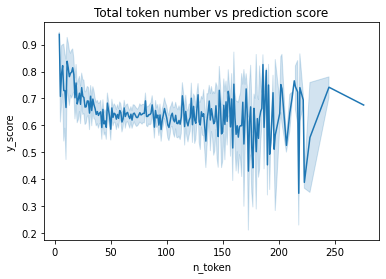

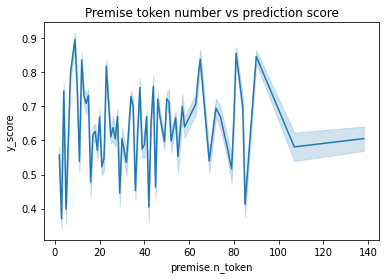

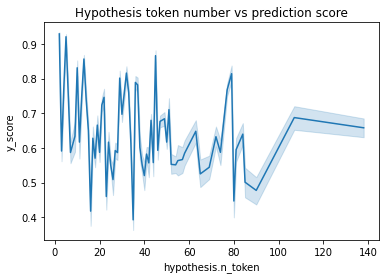

In [21]:
sns.lineplot(inference_sentences, x='n_token', y='y_score')
plt.title('Total token number vs prediction score')
plt.show()

sns.lineplot(inference_sentences, x='premise.n_token', y='y_score')
plt.title('Premise token number vs prediction score')
plt.show()

sns.lineplot(inference_sentences, x='hypothesis.n_token', y='y_score')
plt.title('Hypothesis token number vs prediction score')
plt.show()

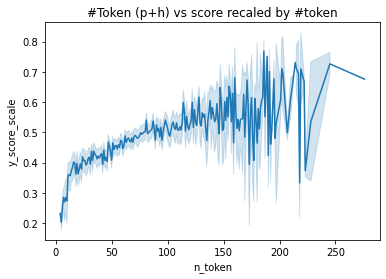

In [22]:
inference_sentences['y_score_scale'] = inference_sentences['y_score'] * (np.log(inference_sentences['n_token'])/np.log(max(inference_sentences['n_token'])) )
sns.lineplot(inference_sentences, x='n_token', y='y_score_scale')

plt.title('#Token (p+h) vs score recaled by #token')
plt.show()

### Bloc relation diagnostic

Does block can link it self? How so?

In [23]:
df_same_bloc = inference_blocs[inference_blocs['source.bloc.index'] == inference_blocs['target.bloc.index']]
print('#Block_same :', len(df_same_bloc))

#Block_same : 29


Generating plot:   0%|          | 0/16 [00:00<?, ?it/s]

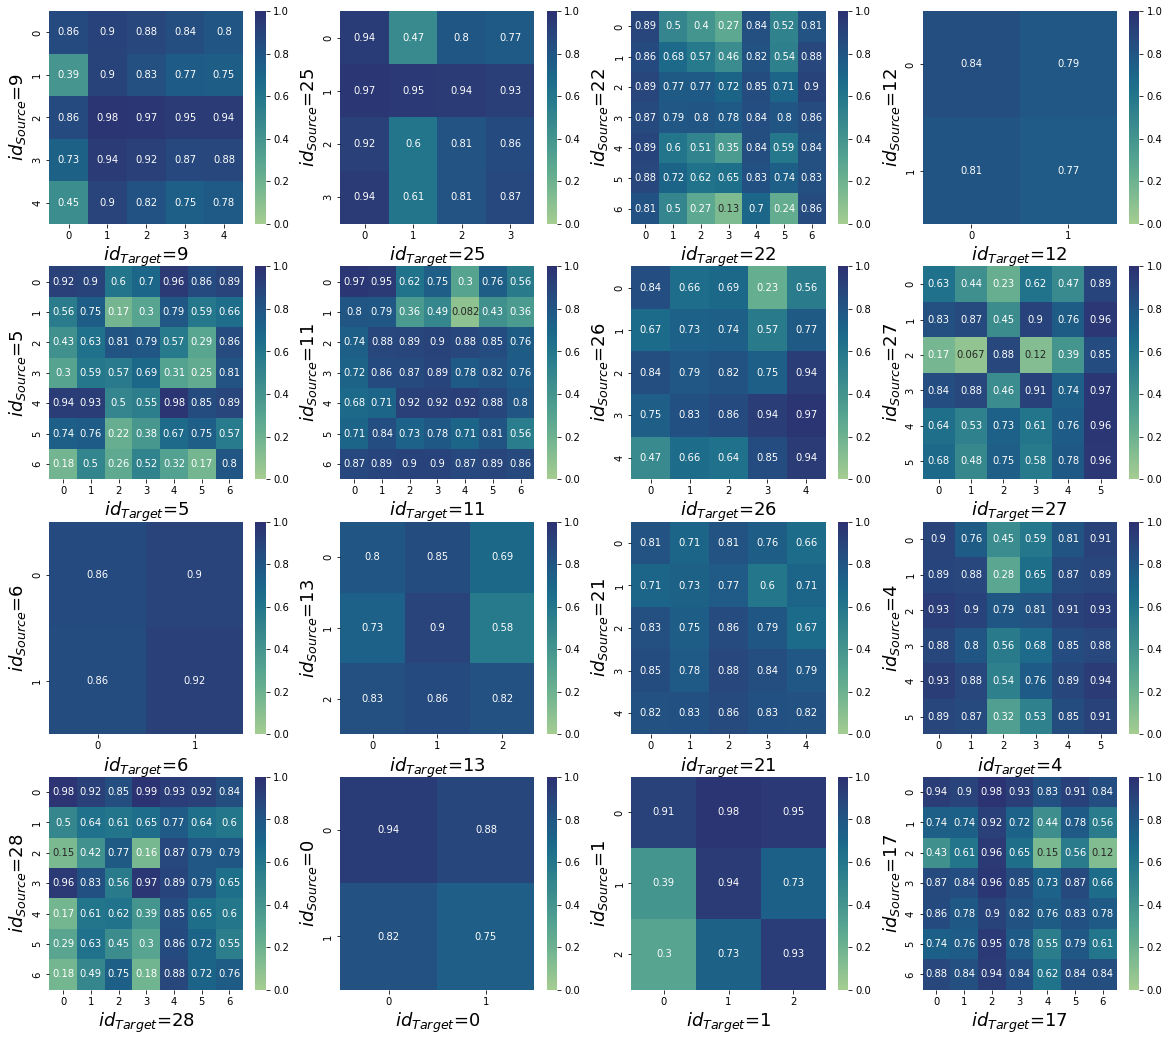

In [24]:
import seaborn as sns
import matplotlib.pylab as plt
from tqdm.auto import tqdm

# Bigger plot 
plt.rcParams["figure.figsize"] = (20, 18)

N_subfig = 16
fig, axes = plt.subplots(4, 4)
c = 0 # col
r = 0 # row

for idx, row in tqdm(df_same_bloc.sample(N_subfig, random_state=100).iterrows(), desc='Generating plot', total=N_subfig):
    y_score = row['y_score_matrix']
    source_bloc_id = row['source.bloc.index']
    target_bloc_id = row['target.bloc.index']
    
    ax = axes[r][c]
    sns.heatmap(y_score, annot=True, vmin=0, vmax=1, cmap="crest", ax=ax)
    ax.set_ylabel('$id_{Source}$=' + str(source_bloc_id), fontsize = 18)
    ax.set_xlabel('$id_{Target}$=' + str(target_bloc_id), fontsize = 18)
    
    
    
    c += 1
    if c == 4:
        c = 0
        r += 1
        
plt.show()

In [25]:
def get_bloc_pair(df_bloc, source, target):
    return df_bloc[(df_bloc['source.bloc.index'] == source) & (df_bloc['target.bloc.index'] == target)].iloc[0]

pair = get_bloc_pair(df_same_bloc, source=25, target=25)

In [26]:
html='<table>'
html += '<tr> <th>Index</th> <th>Source</th> <th>Target</th> <th>Score</th> </tr>'

for s_idx, t_idx, s_tokens, t_tokens, score in zip(pair['source.sentence.index'], 
                                                   pair['target.sentence.index'],
                                                   pair['source.tokens'], 
                                                   pair['target.tokens'], 
                                                   pair['y_score']):
    
    idx = str(s_idx) +'->'+str(t_idx)
    s_str = ' '.join([tk['form'] for tk in s_tokens])
    #s_str = ' '.join(source_tokens)
    t_str = ' '.join([tk['form'] for tk in t_tokens])
    #t_str = ' '.join(target_tokens)
    score = str(round(score, 2))
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +s_str + '</td>' + '<td>' + t_str + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

Index,Source,Target,Score
0->0,Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,0.94
0->1,Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,"Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .",0.47
0->2,Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,Certes il est périble de devenir aussi orphelin sur le plan métaphysique ou social .,0.8
0->3,Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,"Et ïl reste à savoir si l' humanité préférera les illusions de son enfance au contrôle de son destin , ou , plus simplement , si elle saura abandonner les luttes syndicales « rassurantes » qui réclament des sous au père - patron - tout - puissant pour s' aventurer dans l' autogestion créatrice .",0.77
1->0,"Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .",Ainsi l' autogestion ne peut plus être conçue par ses détracteurs comme la douce rêverie de quelques illuminés disciples attardés des utopistes du siècle précédent .,0.97
1->1,"Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .","Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .",0.95
1->2,"Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .",Certes il est périble de devenir aussi orphelin sur le plan métaphysique ou social .,0.94
1->3,"Elle est devenue la revendication immédiate de milliers de travailleurs des secteurs les plus développés ; ils mettent en question de la sorte tous les Christs , les dieux sauveurs , les monarques éclairés , les dirigeants d' avant-garde qui trouvent leur honneur et leur plaisir à « mourir » pour les autres hommes méritant ainsi leur respect , leurs acclamations ou leurs prières .","Et ïl reste à savoir si l' humanité préférera les illusions de son enfance au contrôle de son destin , ou , plus simpl

In [27]:
# Plot to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

How NLI-model find links between different block?

In [31]:
df_diff_bloc = inference_blocs[inference_blocs['source.bloc.index'] != inference_blocs['target.bloc.index']]
print('#Block_diff :', len(df_diff_bloc))

#Block_diff : 812


Generating plot:   0%|          | 0/16 [00:00<?, ?it/s]

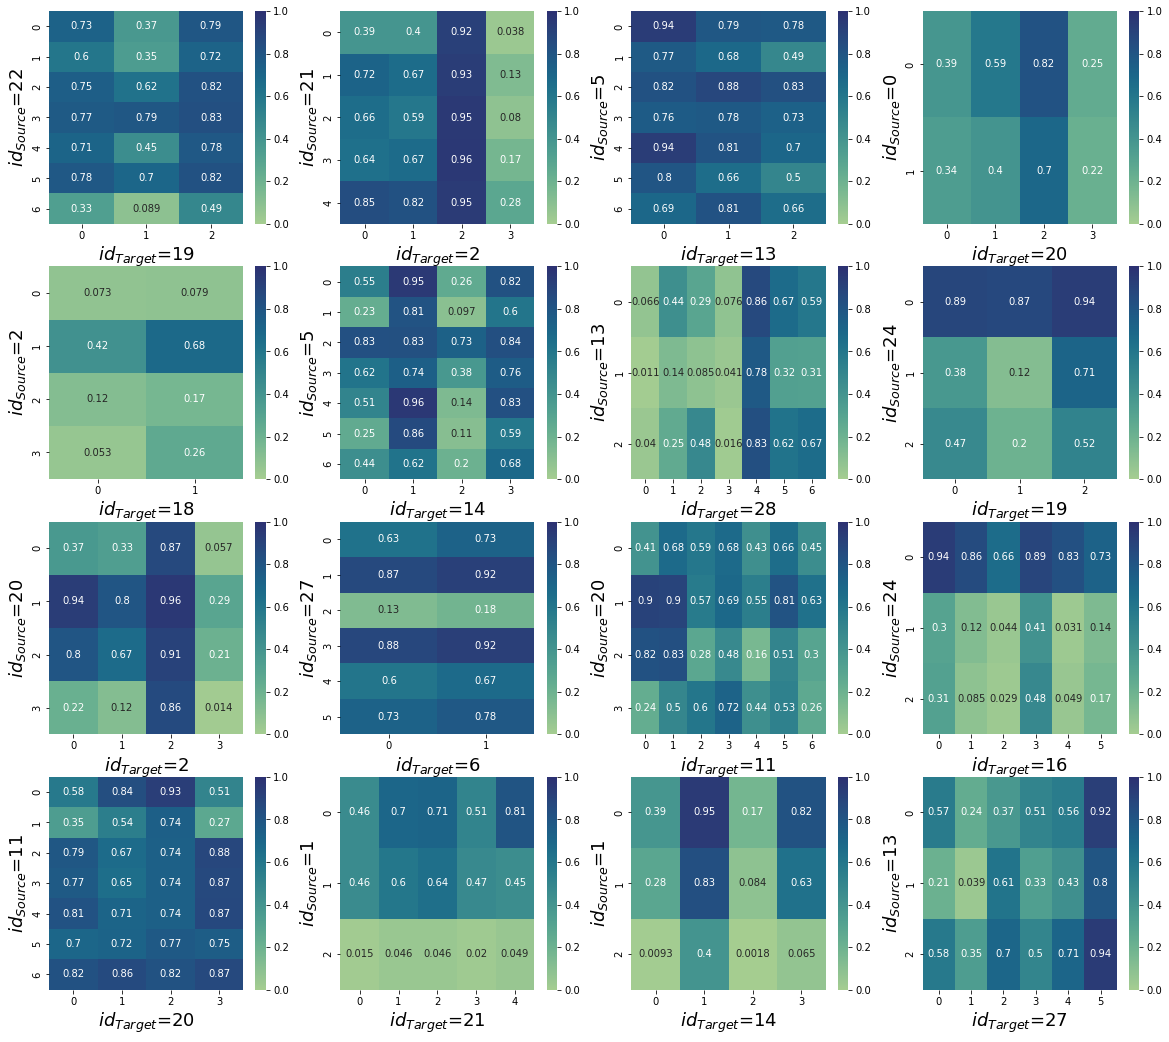

In [32]:
import seaborn as sns
import matplotlib.pylab as plt
from tqdm.auto import tqdm

# Bigger plot 
plt.rcParams["figure.figsize"] = (20, 18)

N_subfig = 16
fig, axes = plt.subplots(4, 4)
c = 0 # col
r = 0 # row

for idx, row in tqdm(df_diff_bloc.sample(N_subfig, random_state=100).iterrows(), desc='Generating plot', total=N_subfig):
    y_score = row['y_score_matrix']
    source_bloc_id = row['source.bloc.index']
    target_bloc_id = row['target.bloc.index']
    
    ax = axes[r][c]
    #sns.heatmap(y_score, annot=True, vmin=0, vmax=1, cmap="crest", ax=ax)
    sns.heatmap(y_score, annot=True, vmin=0, vmax=1, cmap="crest", ax=ax)
    ax.set_ylabel('$id_{Source}$=' + str(source_bloc_id), fontsize = 18)
    ax.set_xlabel('$id_{Target}$=' + str(target_bloc_id), fontsize = 18)
    
    
    
    c += 1
    if c == 4:
        c = 0
        r += 1
        
plt.show()

In [ ]:
[
    [.37, .33, .87, .057],
    [.94, .8, .96, .29],
    [.8, .67, .91, .21],
    [.22, .12, .86, .014]
]

In [33]:
# Plot to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]